In [1]:
import h5py
import os
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import importlib
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

import datasets
import models
import losses

2021-07-19 19:29:14.538786: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(datasets)
filepath = 'datasets/nyu_depth/nyu_depth_v2_labeled.mat'
images, depths = datasets.nyu_depth(filepath, dsize=(224,224))
x_train, x_test, y_train, y_test = train_test_split(images, depths, test_size=0.2)

In [24]:
image_bytes = tf.io.read_file('test.png')
image = tf.image.decode_image(image_bytes)
image = tf.cast(image, tf.float32)
image = tf.expand_dims(image, 0)
# sobel = tf.image.sobel_edges(image)
# sobel_y = np.asarray(sobel[0, :, :, :, 0]) # sobel in y-direction
# sobel_x = np.asarray(sobel[0, :, :, :, 1]) # sobel in x-direction
# Image.fromarray(sobel_y[..., 0] / 4 + 0.5).show()
# Image.fromarray(sobel_x[..., 0] / 4 + 0.5).show()

ssim = tf.image.ssim_multiscale(image[:, :, :, 0:1]/255, image[:, :, :, 1:2]/255, 1.0)
print(ssim)
print(np.max(image))
# Image.fromarray(ssim[..., 0]).show()

tf.Tensor([0.9478167], shape=(1,), dtype=float32)
255.0


In [3]:
def experiment(filename, model, loss, optimizer, batch_size, epochs):
    metrics = tf.keras.metrics.CosineSimilarity()
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))
    model.save(filename, include_optimizer=False)

In [4]:
def evaluate_model(model, x, y):
    f, axarr = plt.subplots(x.shape[0],3)
    f.set_figheight(5*x.shape[0])
    f.set_figwidth(15)
    for i in range(x.shape[0]):
        img = (x_test[i] * 255).astype(np.uint8)
        
        out = model.predict(x_test[i:i+1, :, :, :])

        axarr[i, 0].imshow(x_test[i, :, :])
        axarr[i, 1].imshow(y_test[i, :, :])
        axarr[i, 2].imshow(out[0, :, :, 0])
    plt.show()
    

# Experiments

2021-07-19 19:29:45.558780: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-19 19:29:45.608927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 46 deviceMemorySize: 7.76GiB deviceMemoryBandwidth: 417.23GiB/s
2021-07-19 19:29:45.608968: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-19 19:29:45.612883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-19 19:29:45.612968: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-19 19:29:45.613657: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuf

2021-07-19 19:29:47.081482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-19 19:29:47.104985: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3999980000 Hz
2021-07-19 19:29:47.579610: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-19 19:29:48.346861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2021-07-19 19:29:49.314279: W tensorflow/stream_executor/gpu/asm_compiler.cc:64] Running ptxas --version returned 32512
2021-07-19 19:29:49.395993: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-07-19 19:29:49.414667: I tensorflow/stream_executor/platform/default/dso_load

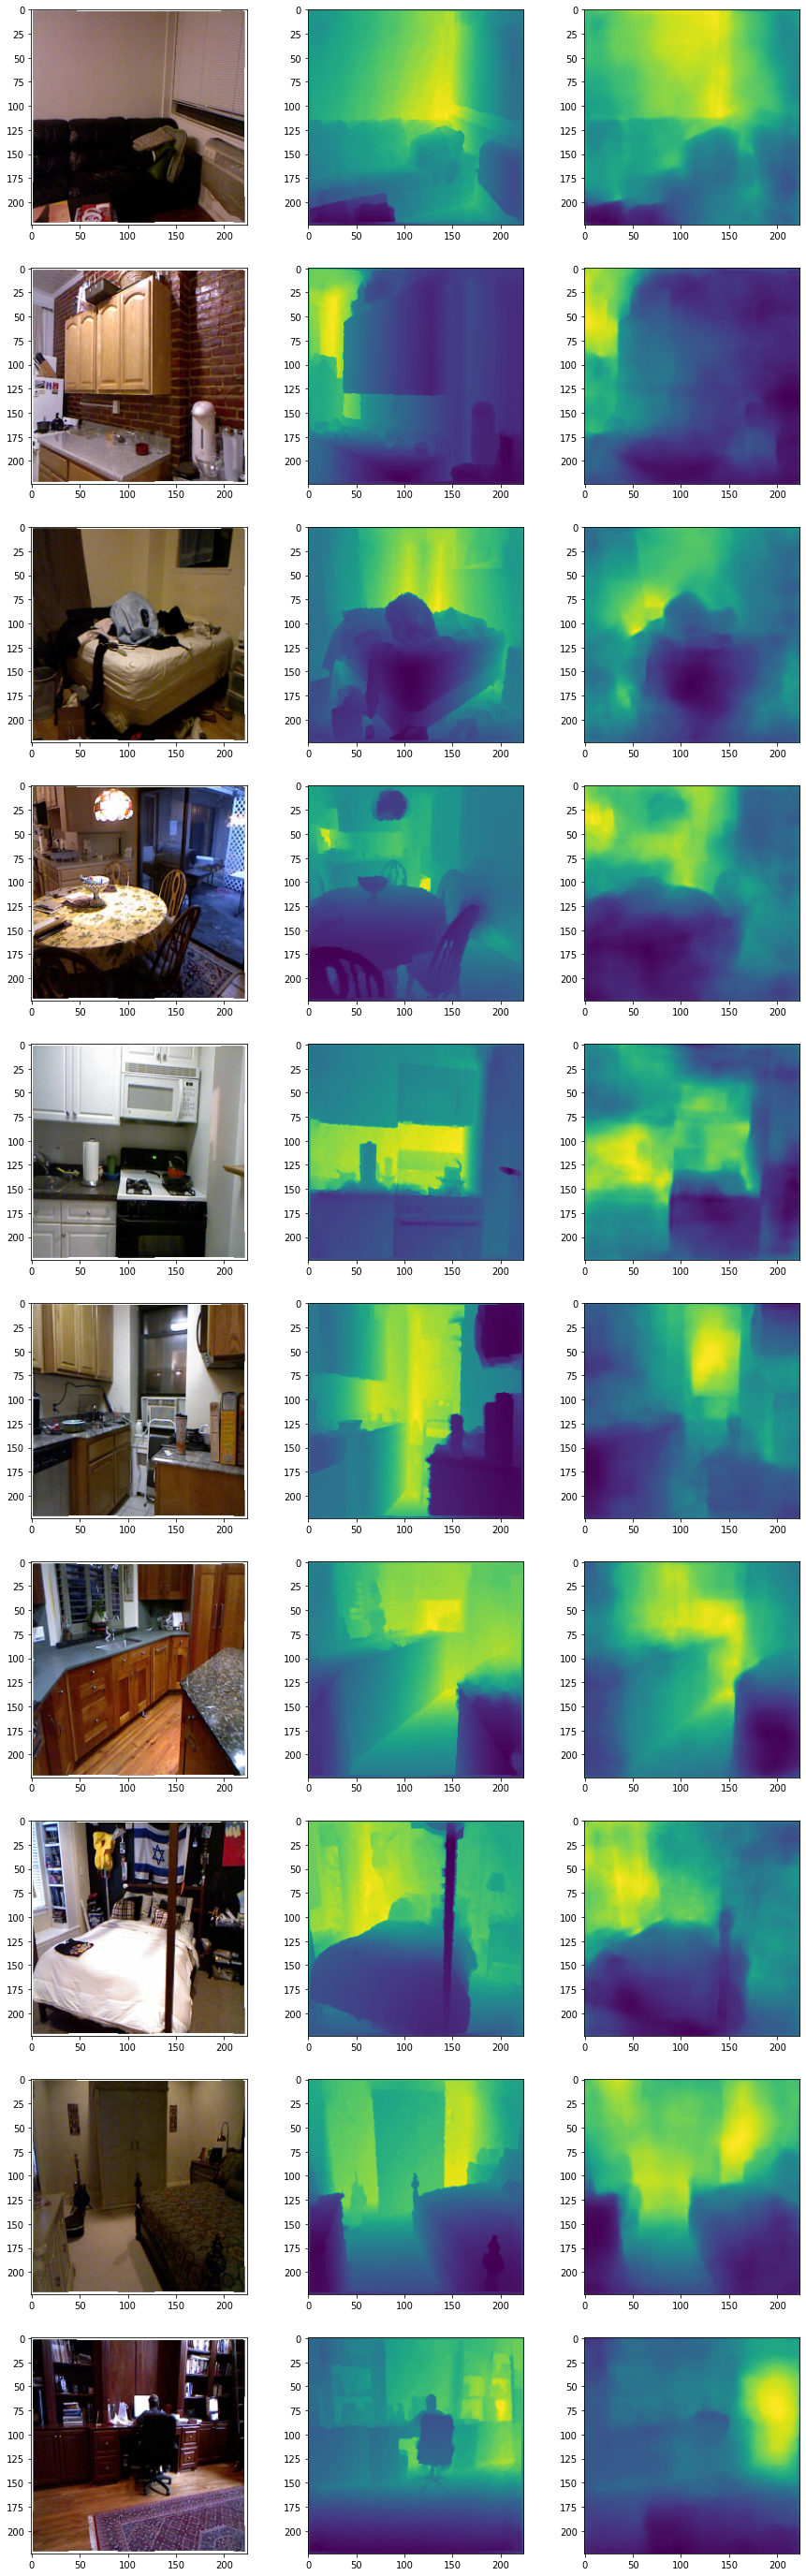

In [5]:
# model: mobilenet unet
# iters: 220, bs: 5, data augmentation: none
# loss: l1 + 0.5*ssim + 0.5*edge
# optimizer: SGD with lr 0.01 and momentum 0.9
m = tf.keras.models.load_model("saved_models/mobilenet_unet_1.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

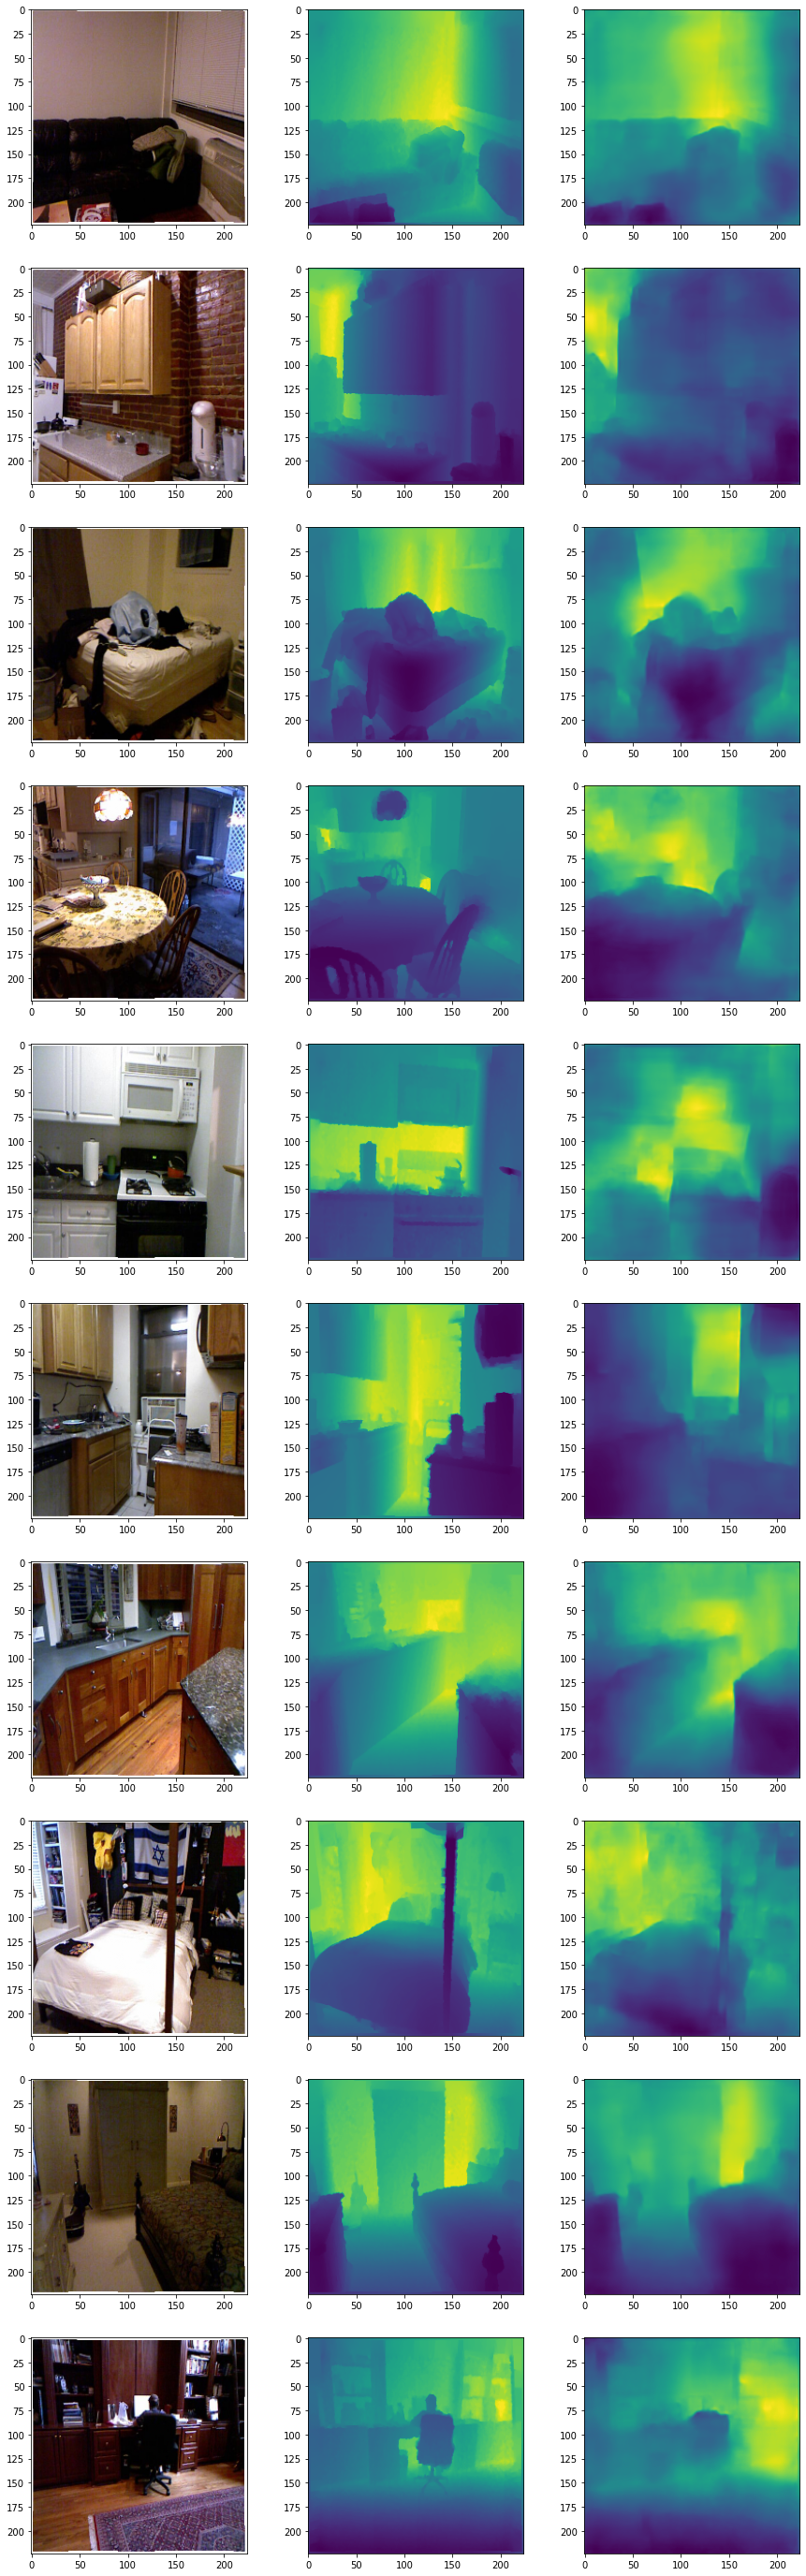

In [6]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: l1 + 0.5*ssim + 0.5*edge
# optimizer: SGD with lr 0.01 and momentum 0.9
m = tf.keras.models.load_model("saved_models/mobilenet_unet_2.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 0.3 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: SGD with lr 0.01 and momentum 0.9
importlib.reload(models)
importlib.reload(losses)
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=0.3, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
experiment("saved_models/mobilenet_unet_3.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_3.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

Epoch 1/450
232/232 [==============================] - 18s 61ms/step - loss: 0.2849 - cosine_similarity: 0.9670 - val_loss: 0.1908 - val_cosine_similarity: 0.9677
Epoch 2/450
232/232 [==============================] - 13s 58ms/step - loss: 0.1951 - cosine_similarity: 0.9692 - val_loss: 0.1910 - val_cosine_similarity: 0.9676
Epoch 3/450
232/232 [==============================] - 13s 57ms/step - loss: 0.1948 - cosine_similarity: 0.9692 - val_loss: 0.1924 - val_cosine_similarity: 0.9677
Epoch 4/450
232/232 [==============================] - 13s 57ms/step - loss: 0.1949 - cosine_similarity: 0.9693 - val_loss: 0.1904 - val_cosine_similarity: 0.9676
Epoch 5/450
232/232 [==============================] - 13s 58ms/step - loss: 0.1948 - cosine_similarity: 0.9693 - val_loss: 0.1900 - val_cosine_similarity: 0.9676
Epoch 6/450
232/232 [==============================] - 13s 57ms/step - loss: 0.1949 - cosine_similarity: 0.9693 - val_loss: 0.1894 - val_cosine_similarity: 0.9677
Epoch 7/450
232/232 [=

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 0.5 * ssim + 0.5 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0.5, edge_weight=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_4.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_4.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 0.3 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=0.3, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_5.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_5.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 0 * ssim + 0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0, edge_weight=0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_6.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_6.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_7.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_7.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 8, data augmentation: none
# loss: 1.0 * l1 + 0.5 * ssim + 0.5 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0.5, edge_weight=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_8.h5", model, loss, optimizer, 8, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_8.h5")
evaluate_model(m,x_test[0:10], y_test[0:10])